## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [1]:
# from <TC_Env> import <TicTacToe> - import your class from environment file
from TCGame_Env import TicTacToe
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt
from tqdm import tqdm

In [7]:
env=TicTacToe()

In [8]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [9]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [10]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

In [11]:
# printing the default tic tac toe board positions
print(Q_state(env.state))
# Printing all the valid actions
print("--------------------------------------")
print(valid_actions(env.state))

x-x-x-x-x-x-x-x-x
--------------------------------------
[(0, 1), (0, 3), (0, 5), (0, 7), (0, 9), (1, 1), (1, 3), (1, 5), (1, 7), (1, 9), (2, 1), (2, 3), (2, 5), (2, 7), (2, 9), (3, 1), (3, 3), (3, 5), (3, 7), (3, 9), (4, 1), (4, 3), (4, 5), (4, 7), (4, 9), (5, 1), (5, 3), (5, 5), (5, 7), (5, 9), (6, 1), (6, 3), (6, 5), (6, 7), (6, 9), (7, 1), (7, 3), (7, 5), (7, 7), (7, 9), (8, 1), (8, 3), (8, 5), (8, 7), (8, 9)]


#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [12]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy
def epsilon_greedy(state, time):
    max_epsilon = 1.0
    min_epsilon = 0.001

    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*time)
    z = np.random.random()       
    if z > epsilon:
        action = max(Q_dict[Q_state(state)],key=Q_dict[Q_state(state)].get)
    else:
        action = random.sample(valid_actions(state),1)[0]   
    
    return action

#### Tracking the state-action pairs for checking convergence - write your code here

In [13]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track =collections.defaultdict(dict)

In [14]:
# Initialise states to be tracked
def initialise_tracking_states():
    Sample_Qvalues = [('x-x-x-x-x-x-x-x-x',(6,5)),('x-x-x-x-x-x-x-x-x',(1,9)),
                       ('x-3-x-x-1-x-x-x-x',(7,5)),('x-5-x-x-x-x-5-7-x',(8,2))]    #select some 4 Q-values
    for q_values in Sample_Qvalues:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []  

In [15]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [16]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [17]:
initialise_tracking_states()

#### Define hyperparameters  ---write your code here

In [18]:
#Defining parameters for the training

EPISODES = 5000000
LR = 0.20
GAMMA = 0.8
threshold = 2540
checkpoint_print_episodes = 600000

### Q-update loop ---write your code here

In [19]:
import time 
start_time = time.time()

q_track={}
q_track['x-3-x-x-x-6-x-x-x']=[]
q_track['x-1-x-x-x-x-8-x-x']=[]
q_track['x-x-x-x-6-x-x-x-5']=[]
q_track['x-x-x-x-9-x-6-x-x']=[]
q_track['x-5-x-2-x-x-4-7-x']=[]
q_track['9-x-5-x-x-x-8-x-4']=[]
q_track['2-7-x-x-6-x-x-3-x']=[]
q_track['9-x-x-x-x-2-x-x-x']=[]
q_track['x-x-7-x-x-x-x-x-2']=[]
q_track['5-x-x-x-x-6-x-x-x']=[]
q_track['4-x-x-6-x-x-3-1-x']=[]
q_track['5-x-8-x-x-6-3-x-x']=[]
q_track['x-6-5-x-2-x-x-3-x']=[]
q_track['7-x-5-x-2-x-x-x-6']=[]   
                    
agent_won_count = 0
env_won_count = 0
tie_count = 0

for episode in tqdm(range(EPISODES)):
    
    env = TicTacToe()
    
    ## Initalizing parameter for the episodes
    reward=0
    curr_state = env.state
    add_to_dict(curr_state)
    is_terminal = False
    total_reward = 0
    
    while not(is_terminal):
        curr_action = epsilon_greedy(curr_state, episode)
    
        if Q_state(curr_state) in q_track.keys():
            q_track[Q_state(curr_state)].append(curr_action)

        next_state,reward,is_terminal, msg = env.step(curr_state,curr_action) 

        curr_lookup = Q_state(curr_state)
        next_lookup = Q_state(next_state)

        if is_terminal:
            q_value_max = 0
            
            # Tracking the count of games won by agent and environment
            if msg == "Agent Won!":
                agent_won_count += 1
            elif msg == "Environment Won!":
                env_won_count += 1
            else:
                tie_count += 1
        else:
            add_to_dict(next_state)
            max_next = max(Q_dict[next_lookup],key=Q_dict[next_lookup].get)
            q_value_max = Q_dict[next_lookup][max_next]

        Q_dict[curr_lookup][curr_action] += LR * ((reward + (GAMMA * (q_value_max))) - Q_dict[curr_lookup][curr_action]) 
        curr_state = next_state

        total_reward += reward

    if (episode + 1) % checkpoint_print_episodes == 0:
        print("After playing %d games, Agent Won : %.4f, Environment Won : %.4f, Tie : %.4f"% (episode + 1, 
            agent_won_count / (episode + 1), env_won_count /(episode + 1), tie_count / (episode + 1)))

    if ((episode + 1) % threshold) == 0:   
        save_tracking_states()

    if ((episode + 1) % 1000000) == 0:
        print('Processed %dM episodes'%((episode+1)/1000000))
        
elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracked')
save_obj(Q_dict,'Policy')
print('Total Execution time: ', elapsed_time)

 12%|█▏        | 600144/5000000 [10:02<1:07:15, 1090.24it/s]

After playing 600000 games, Agent Won : 0.2899, Environment Won : 0.2676, Tie : 0.4424


 20%|██        | 1000120/5000000 [15:26<48:28, 1375.32it/s] 

Processed 1M episodes


 24%|██▍       | 1200148/5000000 [17:57<47:58, 1319.93it/s]  

After playing 1200000 games, Agent Won : 0.4137, Environment Won : 0.2226, Tie : 0.3637


 36%|███▌      | 1800289/5000000 [24:48<34:35, 1541.41it/s]  

After playing 1800000 games, Agent Won : 0.5232, Environment Won : 0.1828, Tie : 0.2940


 40%|████      | 2000245/5000000 [26:55<31:32, 1585.36it/s]

Processed 2M episodes


 48%|████▊     | 2400293/5000000 [31:00<26:13, 1651.95it/s]

After playing 2400000 games, Agent Won : 0.6044, Environment Won : 0.1526, Tie : 0.2430


 60%|██████    | 3000139/5000000 [36:58<19:26, 1714.59it/s]

After playing 3000000 games, Agent Won : 0.6644, Environment Won : 0.1290, Tie : 0.2066
Processed 3M episodes


 72%|███████▏  | 3600167/5000000 [42:51<13:36, 1713.58it/s]

After playing 3600000 games, Agent Won : 0.7105, Environment Won : 0.1104, Tie : 0.1791


 80%|████████  | 4000326/5000000 [46:45<09:42, 1716.67it/s]

Processed 4M episodes


 84%|████████▍ | 4200149/5000000 [48:42<08:01, 1662.49it/s]

After playing 4200000 games, Agent Won : 0.7466, Environment Won : 0.0959, Tie : 0.1575


 96%|█████████▌| 4800160/5000000 [54:32<01:55, 1732.75it/s]

After playing 4800000 games, Agent Won : 0.7753, Environment Won : 0.0846, Tie : 0.1402


100%|██████████| 5000000/5000000 [56:26<00:00, 1476.42it/s]


Processed 5M episodes
Total Execution time:  3386.5851180553436


#### Check the Q-dictionary

In [20]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): 1.7623247716206532,
              (0, 3): 1.9176415488962766,
              (0, 5): 1.3943991397338604,
              (0, 7): 1.1107213320411904,
              (0, 9): 0.6216499068290339,
              (1, 1): 2.668389557849536,
              (1, 3): 2.663148719739538,
              (1, 5): 2.4596204595682396,
              (1, 7): 2.5720680634789765,
              (1, 9): 2.6413366627841612,
              (2, 1): 2.767817421746146,
              (2, 3): 2.5934634237587777,
              (2, 5): 1.8655805565674741,
              (2, 7): 2.063833505268101,
              (2, 9): 4.2836894190952615,
              (3, 1): 3.027219690989664,
              (3, 3): 1.9234750646940306,
              (3, 5): 2.9872423272259208,
              (3, 7): 2.1652825319327533,
              (3, 9): 0.544771014283493,
              (4, 1): 2.4317239701803617,
              (4, 3): 0.9361037125739142,
              (4, 5): 0.7343808114701753,
 

In [21]:
len(Q_dict)

1289947

In [0]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated

#### Check the states tracked for Q-values convergence
(non-evaluative)

In [0]:
# Write the code for plotting the graphs for state-action pairs tracked

### Epsilon - decay check

In [22]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,5000000)
epsilon = []
for i in range(0,5000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

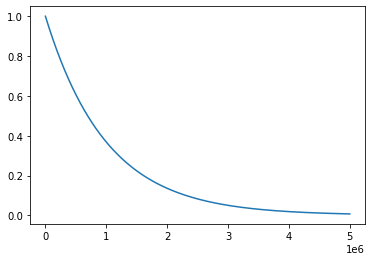

In [23]:
plt.plot(time, epsilon)
plt.show()